In [95]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
#from prophet import Prophet

In [96]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [97]:
df

,Mnd,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
0,Februar-25,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
1,Januar-25,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
2,Desember-24,17.2,21.2,25.4,9.4,5.3,3.9,5.3,3.1,5.8,3.5
3,November-24,18.7,22.4,22.0,9.0,6.6,3.1,5.1,3.4,5.9,3.8
4,Oktober-24,19.9,23.4,20.3,8.8,5.8,3.3,5.5,3.5,5.9,3.7
...,...,...,...,...,...,...,...,...,...,...,...
201,Mai-08,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
202,April-08,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
203,Mars-08,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
204,Februar-08,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0


In [98]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [99]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)





In [100]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [101]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.7801822589557765, p-value: 0.39034408610867655
Hoyre ADF Statistic: -2.2989231540603043, p-value: 0.17231551097951114
Frp ADF Statistic: -1.582571861819359, p-value: 0.49234205741872633
SV ADF Statistic: -1.160916983088228, p-value: 0.6901783573567423
Sp ADF Statistic: -1.6059394874788055, p-value: 0.48060925134060084
KrF ADF Statistic: -1.8947928921859223, p-value: 0.33451464977124046
Venstre ADF Statistic: -2.8586375025689597, p-value: 0.05037365394503086
MDG ADF Statistic: -1.6159866377465042, p-value: 0.47483396704156744
Rodt ADF Statistic: -0.6134683727205307, p-value: 0.8679095925971021
Andre ADF Statistic: -1.7235826457432835, p-value: 0.4190047711122682


In [102]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [109]:
model = VAR(df_diff)  # Use df_diff if differenced data is needed
#model_fitted = model.fit(45)  # Choose lag order (5 is an example, tune this)
model_fitted = model.fit(maxlags=16, ic='aic', method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())
#model_fitted.k_ar

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 16, BIC -> 0, FPE -> 1, HQIC ->  0>
Using 16 based on aic criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 07, Mar, 2025
Time:                     12:05:05
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    7.40537
Nobs:                     189.000    HQIC:                  -8.92003
Log likelihood:           811.796    FPE:                5.60727e-06
AIC:                     -20.0380    Det(Omega_mle):     1.21651e-08
--------------------------------------------------------------------
Results for equation Ap
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
L1.Ap              -2.274355         0.997510           -2.280          

In [110]:
steps = 7  # Number of steps to forecast
alpha = 0.5

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-02-28", periods=steps, freq='ME')
forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


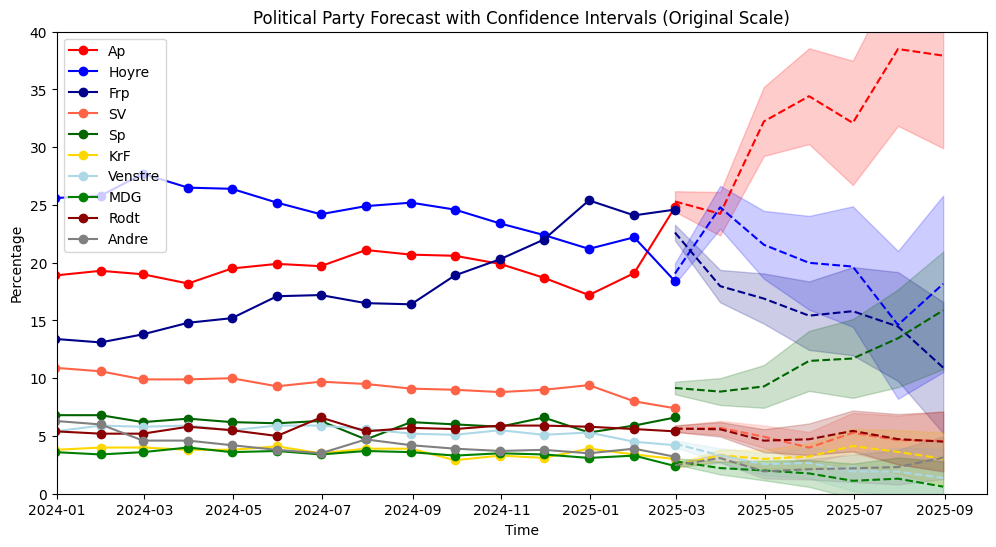

In [111]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)

plt.xlim(np.datetime64("2024-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast with Confidence Intervals (Original Scale)")
plt.legend(loc="upper left")
plt.show()

In [106]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-02-28,23.682842,19.233974,23.121339,5.169823,10.697152,2.249917,4.062564,2.586061,6.595484,1.977204
2025-03-31,23.931010,24.831444,19.236934,4.616388,10.278677,2.800985,2.765112,1.964055,6.061251,2.372493
2025-04-30,31.395748,21.985954,17.858775,3.136450,11.666404,2.968390,1.787708,1.527049,5.645985,1.171356
2025-05-31,34.550695,21.304558,16.606157,1.314895,13.167100,2.897177,1.615072,1.573781,5.543224,1.608492
2025-06-30,34.084513,20.776250,16.487143,2.625173,13.438650,3.423686,0.780878,1.079354,5.067726,1.659943
2025-07-31,41.103241,15.618814,13.174969,1.736286,15.196519,3.632332,1.220645,1.203667,4.747705,2.106027
2025-08-31,42.875618,19.991263,8.384917,1.625227,17.321523,2.721817,0.309115,1.068085,3.809296,2.405696
2025-09-30,43.832528,21.682642,4.540479,1.275823,18.354722,3.702284,0.326327,0.437113,2.966255,2.820066
